In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter
from scipy import stats

In [2]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [3]:
m_cii.update(nuObs = 246*u.GHz,
             Delta_nu = 64*u.GHz,
             dnu = 2.8*u.GHz,
             Omega_field = 4*u.deg**2,
             catalogue_file  = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [4]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma_f = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x, z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma_f(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=False):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

    
from limlam_mocker import limlam_mocker as llm
from limlam_mocker.limlam_mocker import add_log_normal_scatter
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

tablepath = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [71]:
halo_ms = m_cii.halos.M
halo_zs = m_cii.halos.redshift

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))
halo_IR = halo_sfr*(1.36*(10**10))
halo_IR = add_log_normal_scatter(halo_IR, 0.3, seed = 23)

halos_cii = m_cii.L_halos.value

Loading .npz catalogues...


In [72]:
z6 = (halo_zs > 5.9) & (halo_zs < 6.1)
z8 = (halo_zs > 7.5)

print('Total number of halos (z = [5.8, 7.9]) is', len(halo_zs))
print('Total number of halos at z = 6 is', len(halo_zs[z6]))
print('Total number of halos at z = 8 is', len(halo_zs[z8]))

Total number of halos (z = [5.8, 7.9]) is 1882417
Total number of halos at z = 6 is 310483
Total number of halos at z = 8 is 145509


In [13]:
fire_galaxies_z6 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z6.dat'
massive_z6, log_cii_z6, log_ir_z6 = np.loadtxt(fire_galaxies_z6, unpack=True)

mass_fire_z6 = massive_z6 < 0
fire_box_z6 = massive_z6 >= 0
fire_zs_z6 = [6 for i in range(len(massive_z6))]

fire_cii_z6 = 10**(log_cii_z6)
fire_ir_z6 = 10**(log_ir_z6)


fire_galaxies_z8 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z8.dat'
massive_z8, log_cii_z8, log_ir_z8 = np.loadtxt(fire_galaxies_z8, unpack=True)

mass_fire_z8 = massive_z8 < 0
fire_box_z8 = massive_z8 >= 0
fire_zs_z8 = [8 for i in range(len(massive_z8))]

fire_cii_z8 = 10**(log_cii_z8)
fire_ir_z8 = 10**(log_ir_z8)

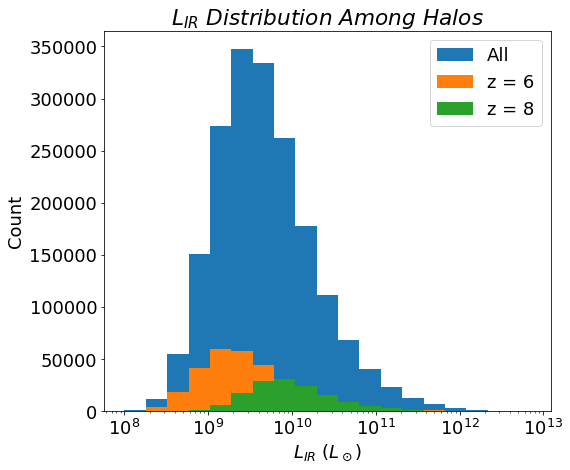

In [73]:
ir_binning = np.logspace(np.log10(10**8), np.log10(7*(10**12)), 20)

plt.hist(halo_IR, bins = ir_binning, label = 'All')
plt.hist(halo_IR[z6], bins = ir_binning, label = 'z = 6')
plt.hist(halo_IR[z8], bins = ir_binning, label = 'z = 8')
plt.xscale('log')

plt.title(r'$L_{IR}\ Distribution\ Among\ Halos$')
plt.xlabel(r'$L_{IR}\ (L_\odot)$')
plt.ylabel('Count')
plt.legend()

ir_bin_center = (ir_binning[:-1] + ir_binning[1:]) / 2

In [39]:
data_z6 = (halos_cii/halo_IR)[z6]
bins_z6 = halo_IR[z6]

data_z8 = (halos_cii/halo_IR)[z8]
bins_z8 = halo_IR[z8]

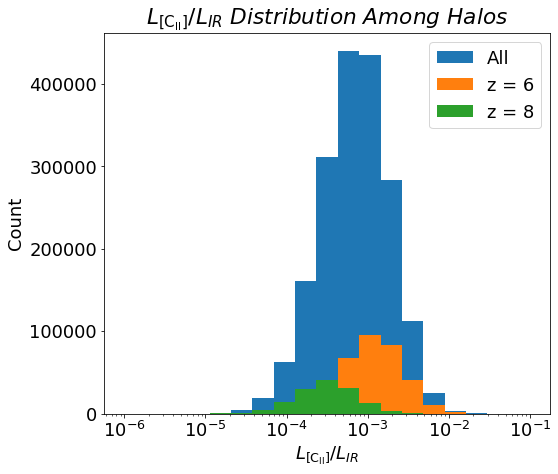

In [48]:
cii_ir_binning = np.logspace(np.log10(10**(-6)), np.log10(10**(-1)), 20)

plt.hist(halos_cii/halo_IR, bins = cii_ir_binning, label = 'All')
plt.hist((halos_cii/halo_IR)[z6], bins = cii_ir_binning, label = 'z = 6')
plt.hist((halos_cii/halo_IR)[z8], bins = cii_ir_binning, label = 'z = 8')
plt.xscale('log')

plt.title(r'$L_{\rm{[C_{II}]}}/L_{IR}\ Distribution\ Among\ Halos$')
plt.xlabel(r'$L_{\rm{[C_{II}]}}/L_{IR}$')
plt.ylabel('Count')
plt.legend()

#ir_bin_center = (ir_binning[:-1] + ir_binning[1:]) / 2

In [51]:
def get_mean(ir, cii, z1, z2, binning):
    
    data_z1 = (cii/ir)[z1]
    bins_z1 = ir[z1]
    
    data_z2 = (cii/ir)[z2]
    bins_z2 = ir[z2]
    
    stat_z1 = stats.binned_statistic(bins_z1, data_z1, 'mean', bins = binning)
    stat_z2 = stats.binned_statistic(bins_z2, data_z2, 'mean', bins = binning)
    
    return stat_z1[0], stat_z2[0]

In [76]:
def get_mean(ir, cii, z, binning):
    
    data_z = (cii/ir)[z]
    bins_z = ir[z]
    
    stat_z = stats.binned_statistic(bins_z, data_z, 'mean', bins = binning)
    
    return stat_z[0]

In [77]:
lcii_lir_mean_z6, lcii_lir_mean_z8  = get_mean(halo_IR, halos_cii, z6, ir_binning), get_mean(halo_IR, halos_cii, z8, ir_binning)

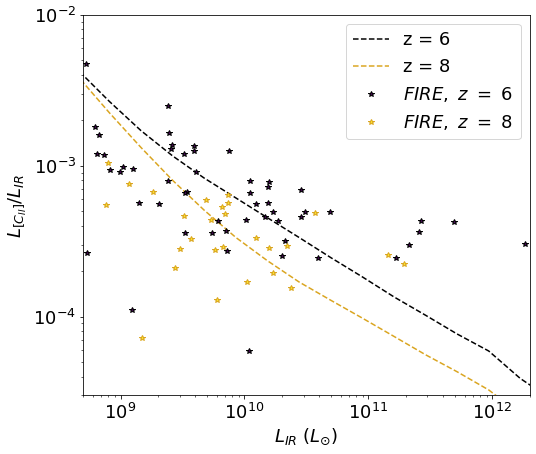

In [78]:
plt.plot(ir_bin_center, lcii_lir_mean_z6, label = 'z = 6', color = 'k', linestyle = '--')
plt.plot(ir_bin_center, lcii_lir_mean_z8, label = 'z = 8', color = '#DAA520', linestyle = '--')

plt.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
plt.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ $8', linestyle = "None")


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

#plt.savefig('paper_figs/fig6_lcii_lir/debug1.pdf', bbox_inches = 'tight')

Second Model

In [59]:
m_cii_v2 = lim('Lichen_v4', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [60]:
m_cii_v2.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            nuObs = 246*u.GHz,
            Delta_nu = 64*u.GHz,
            dnu = 2.8*u.GHz,
            Omega_field = 4*u.deg**2,
            catalogue_file  = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [61]:
halos_cii_v2 = m_cii_v2.L_halos.value

Loading .npz catalogues...


In [62]:
lcii_lir_mean_z6_v2, lcii_lir_mean_z8_v2  = get_mean(halo_IR, halos_cii_v2, z6, z8, ir_binning)

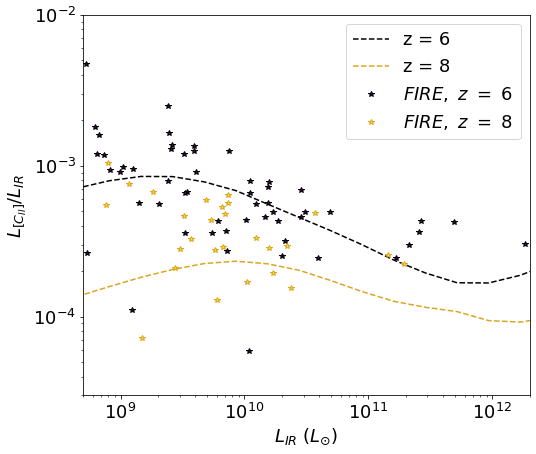

In [66]:
plt.plot(ir_bin_center, lcii_lir_mean_z6_v2, label = 'z = 6', color = 'k', linestyle = '--')
plt.plot(ir_bin_center, lcii_lir_mean_z8_v2, label = 'z = 8', color = '#DAA520', linestyle = '--')

plt.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
plt.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ $8', linestyle = "None")


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

plt.savefig('paper_figs/fig6_lcii_lir/debug2.pdf', bbox_inches = 'tight')

Other lightcones?

In [68]:
lc_paths = '/home/dongwooc/scratchspace/pprun_hiz_npz/'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(lc_paths) if isfile(join(lc_paths, f))]
onlyfiles.remove('pksc2npz_5313591.out')
onlyfiles.remove('pksc2npz.sh')
for i in range(len(onlyfiles)):
    onlyfiles[i] = lc_paths+onlyfiles[i]

In [70]:
m_cii.update(catalogue_file = onlyfiles[0])

In [69]:
onlyfiles[0]

'/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13767.npz'